# Open Images v4

[Open Images](https://storage.googleapis.com/openimages/web/download.html)是一个包含9百万张图像的数据集。这些数据有着图像级别的标注以及数千个类别的边界框。第四版Open Images关注于物体检测，标记了190万张图像中的超过600类物体。

这份Notebook演示了如何从Open Images v4中提取人脸的边界框。

# 准备工作
首先载入一些数据分析必要的模块。

Open Images处理图像外的数据存储为csv格式，pandas是处理csv文件的不二之选。

In [1]:
import pandas as pd

处理的过程中涉及到一些数学运算。

In [2]:
import numpy as np

Matplotlib用来绘制图像与边界框。

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

对于下载好的所有文件，我们采用如下文件存储约定：
```
-open_images_v4        数据集根目录
|-annotation           所有csv文件
|-train                训练用图像
  |-train_00
  |-train_01
  ...
|-validation           验证用图像
|-toolkit
|-open_images.ipynb    本notebook
```

对于训练用图像，由于图像文件分别存储在9个不同的文件夹下，我们需要建立一个图像ID到图像路径的映射。

In [4]:
from file_list_generator import ListGenerator

In [5]:
lg = ListGenerator()
img_list = lg.generate_list(target_dir='/data/dataset/public/open_images', format_list=['jpg'])
print("Total jpeg files: {}".format(len(img_list)))

Total jpeg files: 1784662


In [6]:
img_id_url_map = {}
for each_url in img_list:
    id_from_name = each_url.split('/')[-1].split('.')[-2]
    img_id_url_map[id_from_name] = each_url
print("Total k-v pairs in map: {}".format(len(img_id_url_map)))

Total k-v pairs in map: 1784662


The map is constructed, let's try to get one image from ID to make sure the map is valid.

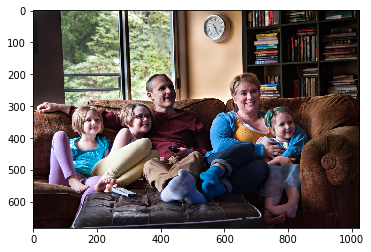

In [7]:
val_img = plt.imread(img_id_url_map['7f111c25a72d31d6'])
plt.imshow(val_img)

如果映射正确，一张五口之家的图像应当显示在上方。

# 数据分析
并非所有的Open Images数据都有边界框。我们发现官方将物体检测这部分数据单独分了出来，称为Subset with Bounding Boxes (600 classes)。这个数据子集共分成5大部分。

- Images
- Boxes
- Image labels
- Image IDs
- Metadata

其中Images顾名思义是图像文件本身。剩下的部分是csv格式文件，我们可以载入看看其具体内容。为了节省时间，我们只对Validation部分进行分析。

## Boxes

载入boxes对应文件并查看其内容。

In [9]:
boxes = pd.read_csv('./annotation/train-annotations-bbox.csv')
print("Total records: {}".format(boxes['Source'].count()))
boxes.head()

Total records: 14610229


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


Boxes顾名思义存储了边界框。同时有两个个重要的参数后边会用到：

- IsGroupOf: 如果边界框内同时包含了多个同类物体，则该项为1。
- IsDepiction: 如果人脸为卡通人物或者绘画作品，该项为1。

## Image labels

载入Image labels对应文件并查看其内容。

In [10]:
image_labels = pd.read_csv('./annotation/train-annotations-human-imagelabels-boxable.csv')
image_labels.head()

,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,verification,/m/014j1m,0
1,000002b66c9c498e,verification,/m/014sv8,1
2,000002b66c9c498e,verification,/m/01599,0
3,000002b66c9c498e,verification,/m/015p6,0
4,000002b66c9c498e,verification,/m/015x4r,0


看上去该文件描述了图像对应的类别名。注意这里的类别名是经过编码的。

## Image IDs

载入Image IDs对应文件并查看其内容。

In [11]:
image_ids = pd.read_csv('./annotation/train-images-boxable-with-rotation.csv')
image_ids.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


看上去这里包含了图像的作者，原始出处以及朝向等。

## Metadata

载入Metadata并查看其内容。

In [12]:
metadata = pd.read_csv('./annotation/class-descriptions-boxable.csv', header=None)
metadata.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


这个文件非常简单，是类别编码与类别名的映射。

以上几个文件所包含的信息足够我们开始提取人脸的工作了。

# 提取人脸
首先，我们需要找到"Human face"所对应的类别代码。

In [13]:
face_label = metadata[metadata[1] == "Human face"].iat[0, 0]
print("对应人脸Human face的类别代码是：{}".format(face_label))

对应人脸Human face的类别代码是：/m/0dzct


然后我们找到属于该类别的所有图像。同时对图像进行初步的筛选：

- 每个边界框内只包含一个人脸。
- 必须是真人的人脸。（可选）

In [14]:
is_face = boxes['LabelName'] == face_label
is_individual = boxes['IsGroupOf'] == 0
is_not_depiction = boxes['IsDepiction'] == 0
face_anns = boxes[is_face & is_individual]
print("筛选后获得数据总数：{}".format(face_anns['ImageID'].count()))
face_anns.head()

筛选后获得数据总数：1027451


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
53,000004f4400f6ec5,xclick,/m/0dzct,1,0.430000,0.496875,0.309991,0.565826,1,0,0,0,0
54,000004f4400f6ec5,xclick,/m/0dzct,1,0.568750,0.683125,0.218487,0.463119,0,0,0,0,0
130,0000271195f2c007,xclick,/m/0dzct,1,0.359375,0.646875,0.372917,0.916667,0,0,0,0,0
289,0000418f7ade0445,xclick,/m/0dzct,1,0.356667,0.400000,0.310000,0.386667,0,0,0,0,0
773,00006c07d2b033d1,xclick,/m/0dzct,1,0.325000,0.464063,0.229687,0.421875,0,0,0,0,0


接下来随机选择一幅图像，并将标注绘制在图像上。

Image id: b7dd66c0bd035116


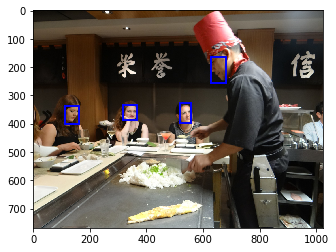

In [15]:
img_id = np.random.choice(face_anns['ImageID'])
print("Image id: {}".format(img_id))
img = plt.imread(img_id_url_map[img_id])

# Be careful sometimes the image is of gray format that there is only one channel. As the neural networks most likely require a fixed input channel, it would be better to convert the image into 3 channel.
img_height, img_width = img.shape[:2]

# Try to draw the annotation.
chosen_anns = face_anns[face_anns['ImageID'] == img_id]
bboxes = chosen_anns.loc[:, ['XMin', 'XMax', 'YMin', 'YMax']].values
currentAxis = plt.gca()
for each_box in bboxes:
    rect = Rectangle((each_box[0]*img_width, each_box[2]*img_height), 
                     (each_box[1] - each_box[0])*img_width, 
                     (each_box[3] - each_box[2])*img_height,
                     linewidth = 2,
                     edgecolor = 'b',
                     facecolor='None'
                    )
    currentAxis.add_patch(rect)
plt.imshow(img)
# chosen_anns